In [114]:
import glob
import random
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim import corpora, models
from tqdm import tqdm
import numpy as np

stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in simple_preprocess(text, min_len = 4):
        if token not in STOPWORDS:
            result.append(lemmatize_stemming(token))
    return result

cat_list = glob.glob ("cuisines/*")
cat_size = len(cat_list)

random.seed(0)
cat_names = []
cat_text = []
# sample_size = min(30, cat_size)
# cat_sample = sorted(random.sample(range(cat_size), sample_size))
cat_sample = range(0, cat_size)

count = 0
for i in cat_sample:
    cat_names.append(cat_list[i].replace("\\", "/").split('/')[-1][:-4].replace("_"," "))
    with open(cat_list[i]) as f:
        cat_text.append(f.read().replace("\n", "").replace("\r",""))

processed_docs = [preprocess(text) for text in tqdm(cat_text)]
dictionary = corpora.Dictionary(processed_docs)
print("Before prunn:%d"%(len(dictionary)))
dictionary.filter_extremes(no_above=0.5)
print("After prunn:%d"%(len(dictionary)))
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]


 43%|██████████████████████████████████▊                                              | 70/163 [17:17<10:58,  7.08s/it]


 88%|██████████████████████████████████████████████████████████████████████▏         | 143/163 [28:26<02:01,  6.07s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [33:00<00:00, 10.07s/it]

Before prunn:193503
After prunn:43491


In [185]:
import math

def cosine_similarity(a, b):
    b = dict(b)
    norm_a = 0
    norm_b = 0
    denom = 0
    for a_i, a_v in a:
        norm_a += a_v * a_v
        if a_i in b:
            denom += a_v * b[a_i]
    for b_i in b:
        norm_b += b[b_i] * b[b_i]
    
    norm_a = math.sqrt(norm_a)
    norm_b = math.sqrt(norm_b)
#     print(norm_a)
#     print(norm_b)
#     print(denom)
    
    return denom / (norm_a * norm_b)

def top_n(df, n, thresh_hold = 0.1):
    df_count = np.zeros(df.shape)
    df_bak = df
    df_count[df >= thresh_hold] = 1
    _counts = np.sum(df_count, axis=1)
    max_index = []
    for i in range(0, n):
        _index = np.argmax(_counts)
        max_index.append(_index)
        _counts[_index] = -1
    
    return df.iloc[max_index][df.columns[max_index]]

In [187]:
import numpy as np
import pandas as pd

sim = np.zeros([len(corpus), len(corpus)])

for i in tqdm(range(0, len(corpus) - 1)):
    sim[i][i] = 1
    for j in range(i + 1, len(corpus)):
        sim[i][j] = cosine_similarity(corpus[i], corpus[j])
        sim[j][i] = sim[i][j]
        

sim_df = pd.DataFrame(sim)
sim_df.index = cat_names
sim_df.columns = cat_names
data = top_n(sim_df, 50)


 41%|█████████████████████████████████▌                                               | 67/162 [00:19<00:22,  4.17it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [00:29<00:00,  5.57it/s]

In [200]:
def format_obj(df, groups):
    _nodes = "nodes"
    _links = "links"
    json_obj = {_nodes:[], _links:[]}
    for i in range(0, len(df.columns)):
        json_obj[_nodes].append({"name":df.columns[i], "group":groups[i]})
    
    for i in range(0, df.shape[0] - 1):
        for j in range(i + 1, df.shape[0]):
            json_obj[_links].append({"source":i, "target":j, "value":df.iloc[i][j]})
    
    return json_obj

In [212]:
import json

with open("display/output.json", "w") as f:
    f.write(json.dumps(format_obj(data, np.ones(data.shape[0]))))

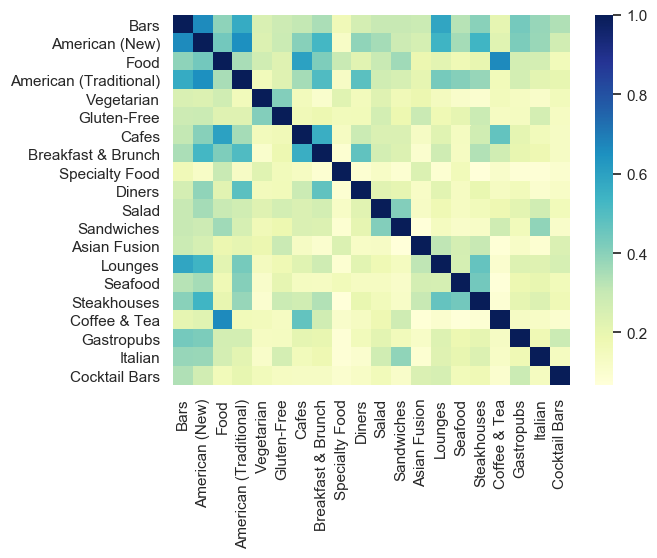

In [220]:
import seaborn as sns; 
import matplotlib.pyplot as plt

sample = 20
ax = sns.heatmap(data.iloc[0:sample][data.columns[0:sample]],cmap="YlGnBu", xticklabels=True, yticklabels=True)
plt.show()